In [29]:
import os
import pickle
from pathlib import Path
from pprint import pprint

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pybullet as p
import tensorflow as tf
from scipy.spatial import ConvexHull

from ravens.utils import utils


In [39]:
COLORS = {
    "blue": [078.0 / 255.0, 121.0 / 255.0, 167.0 / 255.0],
    "red": [255.0 / 255.0, 087.0 / 255.0, 089.0 / 255.0],
    "green": [089.0 / 255.0, 169.0 / 255.0, 079.0 / 255.0],
    "orange": [242.0 / 255.0, 142.0 / 255.0, 043.0 / 255.0],
    "yellow": [237.0 / 255.0, 201.0 / 255.0, 072.0 / 255.0],
    "purple": [176.0 / 255.0, 122.0 / 255.0, 161.0 / 255.0],
    "pink": [255.0 / 255.0, 157.0 / 255.0, 167.0 / 255.0],
    "cyan": [118.0 / 255.0, 183.0 / 255.0, 178.0 / 255.0],
    "brown": [156.0 / 255.0, 117.0 / 255.0, 095.0 / 255.0],
    "gray": [186.0 / 255.0, 176.0 / 255.0, 172.0 / 255.0],
}


def plot_success(
    ylabel,
    xlabel,
    data,
    ax,
    xlim=[None, None],
    xticks=None,
    ylim=[None, None],
    show_std=True,
):
    """Plot frame data."""
    # Data is a dictionary that maps experiment names to tuples with 3
    # elements: x (size N array) and y (size N array) and y_std (size N array)

    # Get data limits.
    for name, (x, y, _) in data.items():
        y = np.array(y)
        xlim[0] = xlim[0] if xlim[0] is not None else np.min(x)
        xlim[1] = xlim[1] if xlim[1] is not None else np.max(x)
        ylim[0] = ylim[0] if ylim[0] is not None else np.min(y)
        ylim[1] = ylim[1] if ylim[1] is not None else np.max(y)

    # Draw background.
    # ax.set_title(title, fontsize=14)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.grid(True, linestyle="-", color=[0.8, 0.8, 0.8])
    _ax = plt.gca()
    for axis in ["top", "bottom", "left", "right"]:
        _ax.spines[axis].set_color("#000000")
    plt.rcParams.update({"font.size": 14})
    plt.rcParams["mathtext.default"] = "regular"
    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42

    # Draw data.
    color_iter = 0
    for name, (x, y, std) in data.items():
        x, y, std = np.float32(x), np.float32(y), np.float32(std)
        upper = np.clip(y + std, ylim[0], ylim[1])
        lower = np.clip(y - std, ylim[0], ylim[1])
        color = COLORS[list(COLORS.keys())[color_iter]]
        if show_std:
            ax.fill_between(
                x, upper, lower, color=color, linewidth=0, alpha=0.3, label=name
            )
        ax.plot(x, y, color=color, linewidth=2, marker="o", alpha=1.0)
        color_iter += 1

    if xticks:
        ax.set_xticks(ticks=range(len(xticks)), labels=xticks)
    ax.legend(loc="lower right", fontsize=14)
    plt.tight_layout()


def plot_points(ax, place_positions, draw_convex=True):
    ax.plot(
        place_positions[-1][:, 0],
        place_positions[-1][:, 1],
        "x",
        color=COLORS["green"],
        alpha=1,
    )
    if draw_convex:
        hull = ConvexHull(place_positions[-1])
        for simplex in hull.simplices:
            ax.plot(
                place_positions[-1][simplex, 0],
                place_positions[-1][simplex, 1],
                "--",
                color=COLORS["green"],
                alpha=0.7,
            )
    ax.plot(
        place_positions[1][:, 0],
        place_positions[1][:, 1],
        "o",
        color=COLORS["blue"],
    )
    ax.plot(
        place_positions[0][:, 0], place_positions[0][:, 1], "o", color=COLORS["red"]
    )
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    plt.tight_layout()


def plot_orientations(ax, place_orientations):
    ax.plot(
        np.real(np.exp(1j * place_orientations[-1])),
        np.imag(np.exp(1j * place_orientations[-1])),
        "x",
        color=COLORS["green"],
        alpha=1,
    )
    ax.plot(
        np.real(np.exp(1j * place_orientations[1])),
        np.imag(np.exp(1j * place_orientations[1])),
        "o",
        color=COLORS["blue"],
    )
    ax.plot(
        np.real(np.exp(1j * place_orientations[0])),
        np.imag(np.exp(1j * place_orientations[0])),
        "o",
        color=COLORS["red"],
    )
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    plt.tight_layout()


In [7]:
with open(
    "predictions/block-insertion-transporter-100-0/block-insertion-transporter-100-0-50.pkl",
    "rb",
) as f:
    "predictions/block-insertion-transporter-100-0/block-insertion-transporter-100-0-50.pkl",
np.mean([d[0] for d in data])
) as f:
    data = pickle.load(f)
np.mean([d[0] for d in data])


0.76

In [73]:
def compute_score_per_step(path_to_predictions, name):
    curve = {"score": [], "nb_action": [], "done": []}
    for fname in tf.io.gfile.listdir(str(path_to_predictions)):
        fname = os.path.join(path_to_predictions, fname)
        if name in fname and ".pkl" in fname:
            n_steps = int(fname[(fname.rfind("-") + 1) : -4])
            data = pickle.load(open(fname, "rb"))
            rewards = []
            actions = []
            dones = []
            for reward, nb_actions, _ in data:
                rewards.append(reward)
                actions.append(nb_actions)
                if reward >= 0.999:
                    dones.append(1)
                else:
                    dones.append(0)
            score = np.mean(rewards)
            std = np.std(rewards)
            curve["score"].append((n_steps, score, std))

            nb_action = np.mean(actions)
            std = np.std(actions)
            curve["nb_action"].append((n_steps, nb_action, std))

            done = np.mean(dones)
            std = np.std(dones)
            curve["done"].append((n_steps, done, std))

        curve["score"].sort()
        curve["nb_action"].sort()
        curve["done"].sort()
    return {k: np.array(v) for k, v in curve.items()}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


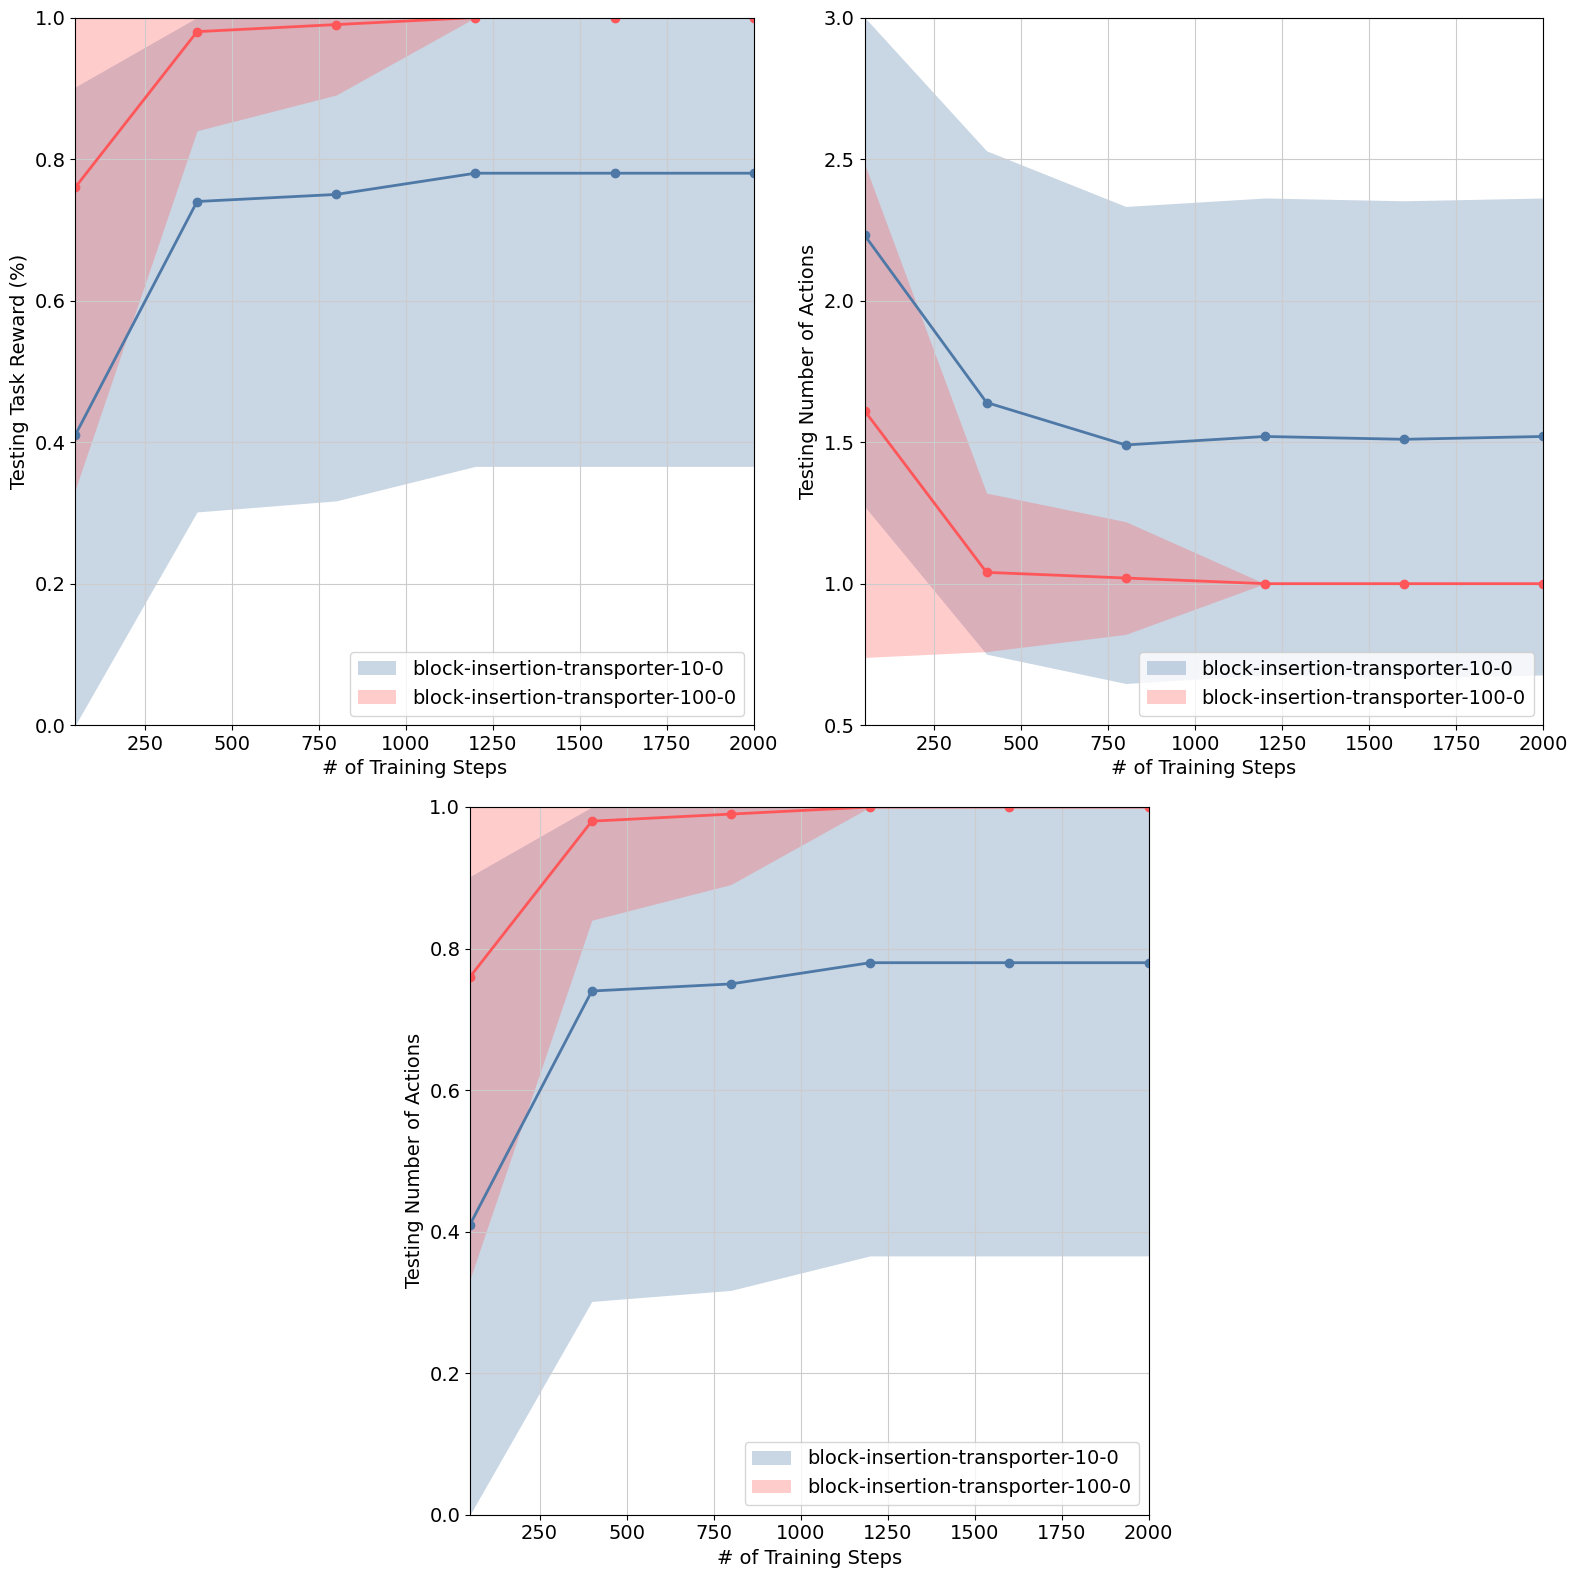

In [115]:
task = "block-insertion"
agent = "transporter"
train_run = 0
logs = {"score": {}, "nb_action": {}, "done": {}}

np.random.seed(train_run)
tf.random.set_seed(train_run)

ylabel_score = "Testing Task Reward (%)"
ylabel_nb_action = "Testing Number of Actions"
ylabel_done = "Testing Task Success (%)"
xlabel = "# of Training Steps"


for n_demos in [10, 100]:
    path_to_predictions = f"predictions/{task}-{agent}-{n_demos}-{train_run}/"
    name = f"{task}-{agent}-{n_demos}-{train_run}"

    # Load and print results to console.
    curve = compute_score_per_step(path_to_predictions, name)
    # Plot results over training steps.
    for metric in ["score", "nb_action", "done"]:
        logs[metric][name] = (
            curve[metric][:, 0],
            curve[metric][:, 1],
            curve[metric][:, 2],
        )

fig2 = plt.figure(constrained_layout=True, figsize=(16, 16))
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(
    gs[0, :2],
)
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
plot_success(
    ylabel_score, xlabel, data=logs["score"], ax=ax1, ylim=[0, 1], xlim=[50, 2000]
)
plot_success(
    ylabel_nb_action,
    xlabel,
    data=logs["nb_action"],
    ax=ax2,
    ylim=[0.5, 3],
    xlim=[50, 2000],
)
plot_success(
    ylabel_nb_action,
    xlabel,
    data=logs["done"],
    ax=ax3,
    ylim=[0, 1],
    xlim=[50, 2000],
)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


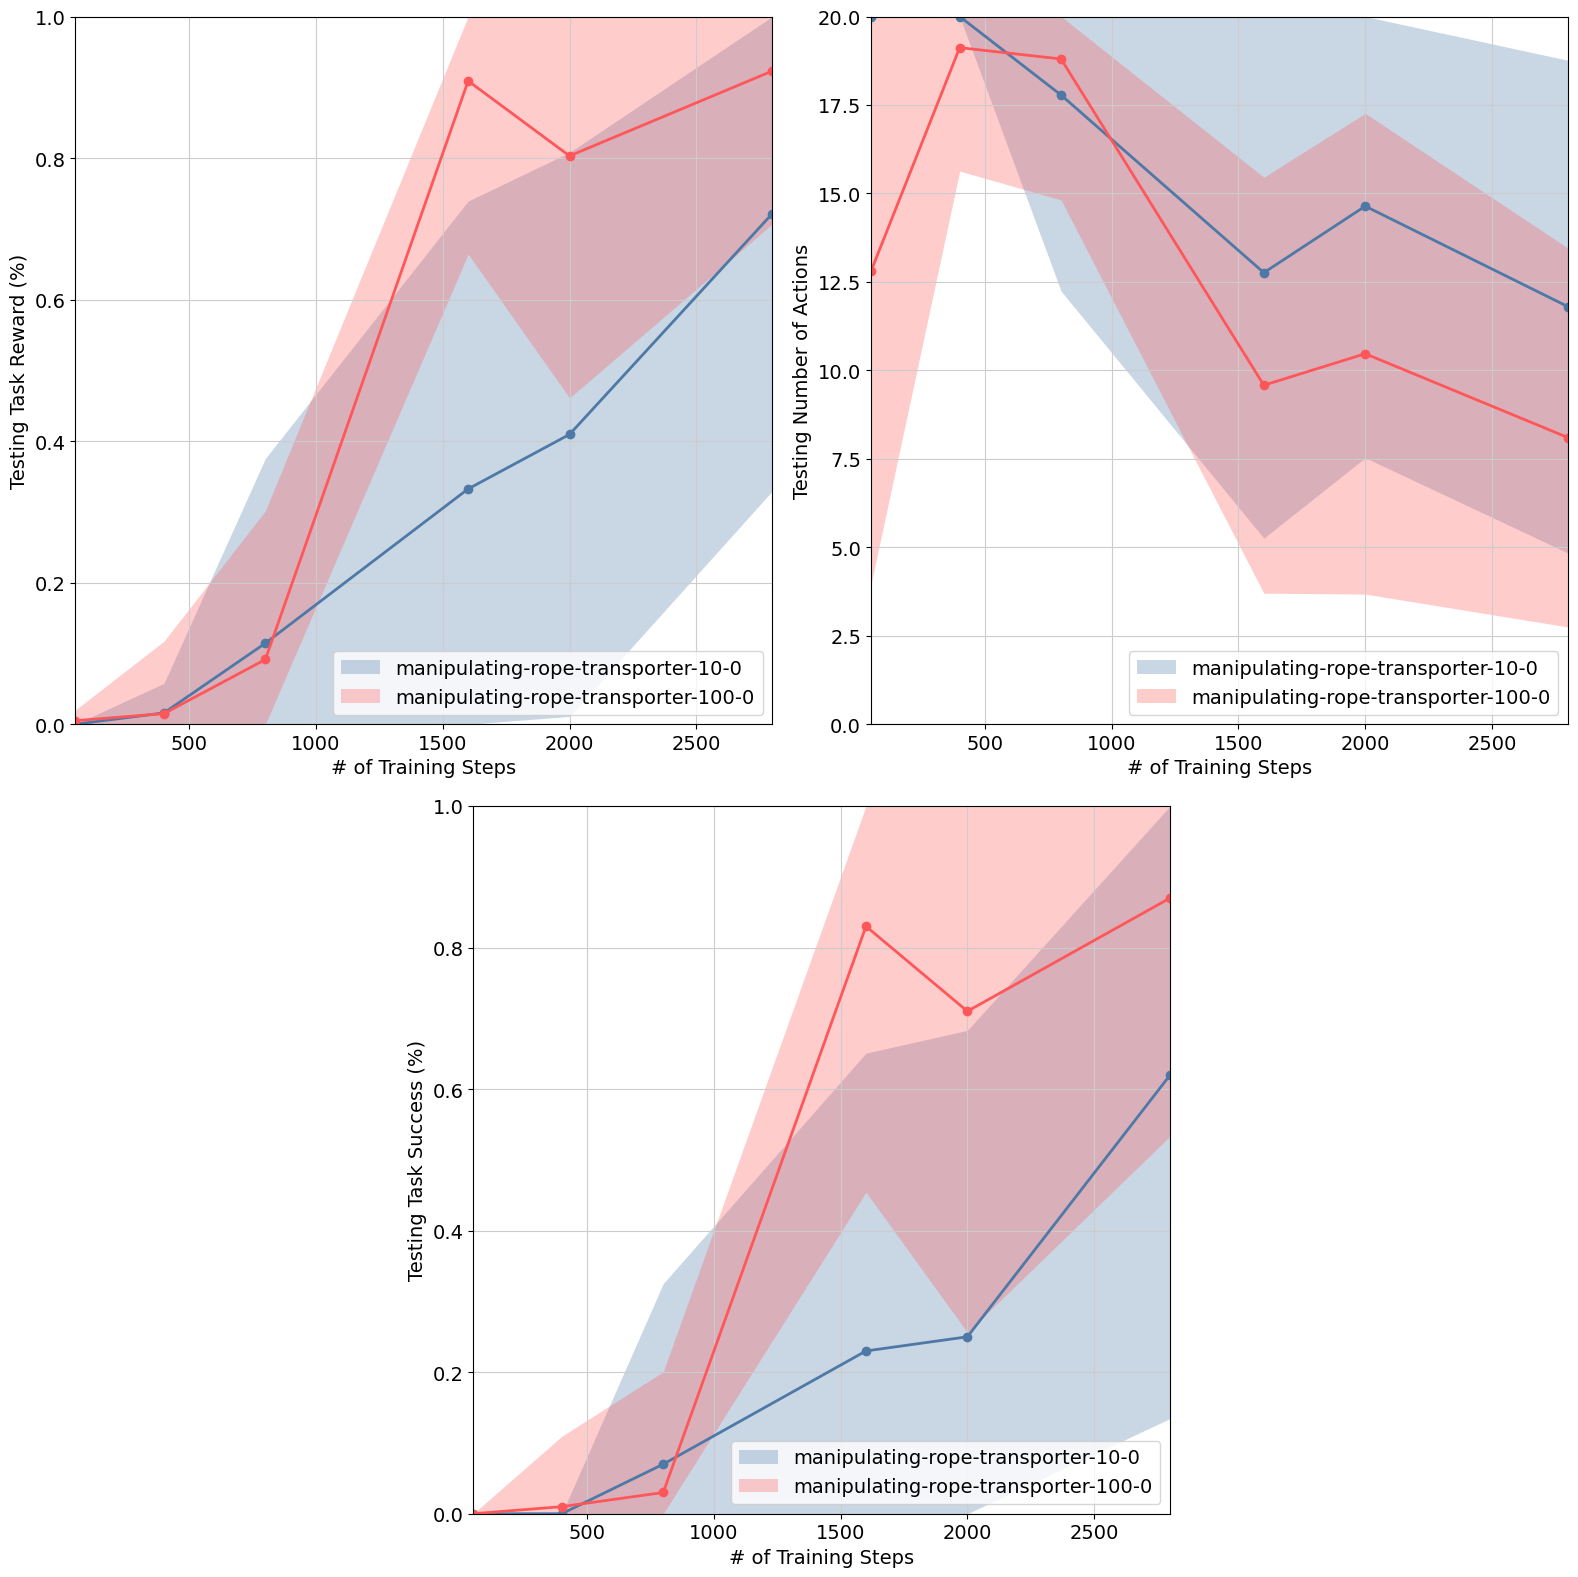

In [116]:
task = "manipulating-rope"
agent = "transporter"
train_run = 0
logs = {"score": {}, "nb_action": {}, "done": {}}

np.random.seed(train_run)
tf.random.set_seed(train_run)

ylabel_score = "Testing Task Reward (%)"
ylabel_nb_action = "Testing Number of Actions"
ylabel_done = "Testing Task Success (%)"
xlabel = "# of Training Steps"


for n_demos in [10, 100]:
    path_to_predictions = f"predictions/{task}-{agent}-{n_demos}-{train_run}/"
    name = f"{task}-{agent}-{n_demos}-{train_run}"

    # Load and print results to console.
    curve = compute_score_per_step(path_to_predictions, name)
    # Plot results over training steps.
    for metric in ["score", "nb_action", "done"]:
        logs[metric][name] = (
            curve[metric][:, 0],
            curve[metric][:, 1],
            curve[metric][:, 2],
        )

fig2 = plt.figure(constrained_layout=True, figsize=(16, 16))
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(
    gs[0, :2],
)
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
plot_success(
    ylabel_score, xlabel, data=logs["score"], ax=ax1, ylim=[0, 1], xlim=[50, 2800]
)
plot_success(
    ylabel_nb_action,
    xlabel,
    data=logs["nb_action"],
    ax=ax2,
    ylim=[0, None],
    xlim=[50, 2800],
)
plot_success(
    ylabel_done,
    xlabel,
    data=logs["done"],
    ax=ax3,
    ylim=[0, 1],
    xlim=[50, 2800],
)


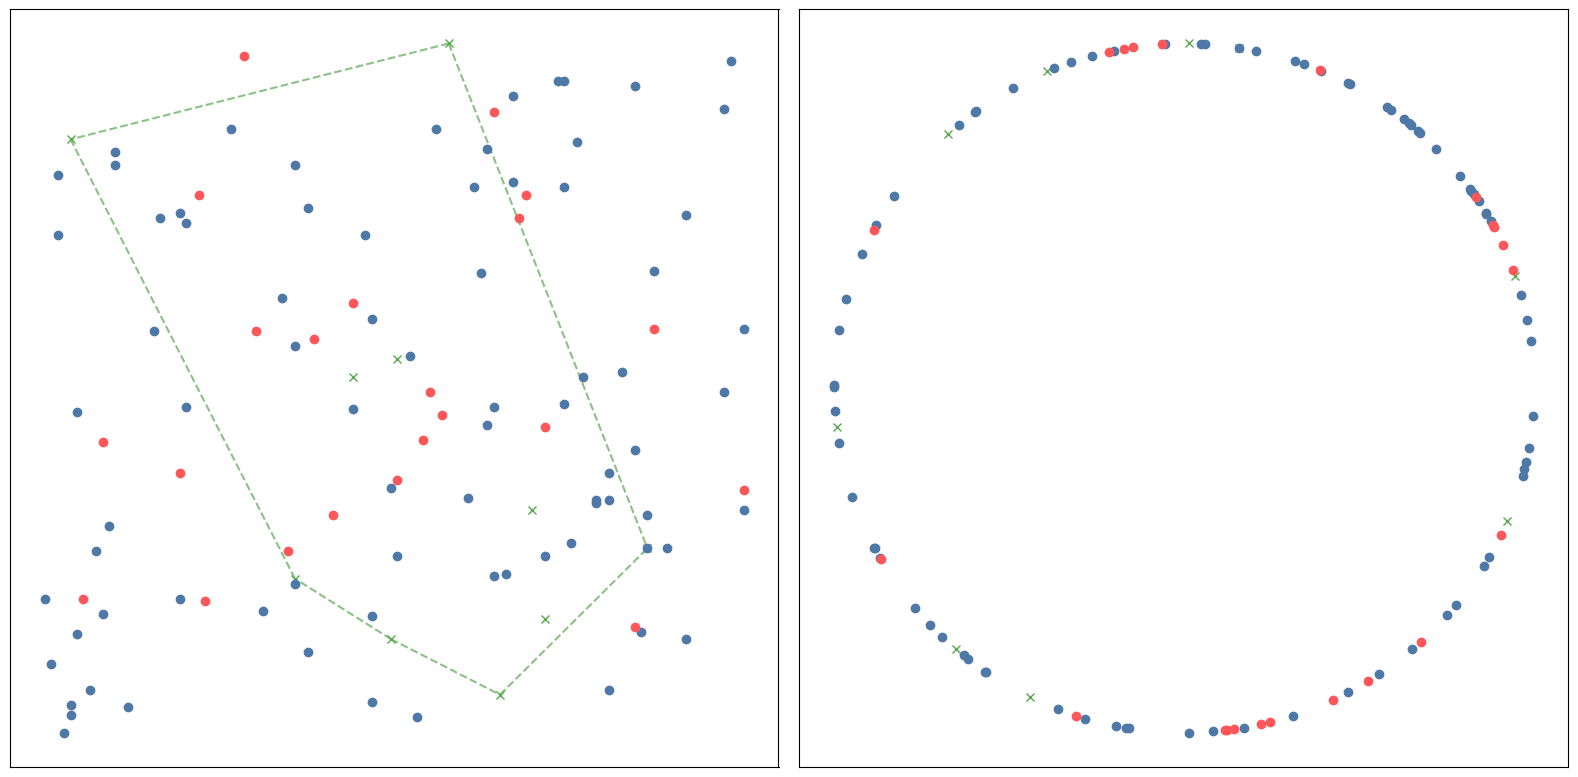

In [78]:
task = "block-insertion"
agent = "transporter"
train_run = 0
n_demos = 10

np.random.seed(train_run)
tf.random.set_seed(train_run)

episodes = np.random.choice(1000, n_demos, False)
path_to_infos = Path(f"dataset/{task}-train/info/")

data = pickle.load(
    open(
        os.path.join(
            f"predictions/{task}-{agent}-{n_demos}-{train_run}/",
            f"{task}-{agent}-{n_demos}-{train_run}-2000.pkl",
        ),
        "rb",
    )
)

place_positions = {-1: [], 0: [], 1: []}
place_orientations = {-1: [], 0: [], 1: []}
for episode in episodes:
    info_path = [
        f for f in path_to_infos.glob("{:>6}*.pkl".format(episode).replace(" ", "0"))
    ][0]
    with open(info_path, "rb") as file:
        info = pickle.load(file)
    place_positions[-1].append(info[0][6][0])
    place_orientations[-1].append(p.getEulerFromQuaternion(info[0][6][1]))

for episode_info in data:
    place_positions[episode_info[0]].append(episode_info[2][-1][6][0])
    place_orientations[episode_info[0]].append(
        p.getEulerFromQuaternion(episode_info[2][-1][6][1])
    )

place_positions = {k: np.array(v)[:, :2] for k, v in place_positions.items()}
place_orientations = {k: np.array(v)[:, 2] for k, v in place_orientations.items()}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_points(axs[0], place_positions, draw_convex=True)
plot_orientations(axs[1], place_orientations)


In [117]:
def compute_reward_per_env(task, agent, n_demos, step):
    train_run = 0
    path_to_dataset = os.path.join("dataset/", f"{task}-test")
    path_to_predictions = f"predictions/{task}-{agent}-{n_demos}-{train_run}/{task}-{agent}-{n_demos}-{train_run}-{step}.pkl"
    color_path = os.path.join(path_to_dataset, "action")
    fnames = {}
    predictions = pickle.load(open(path_to_predictions, "rb"))
    counter = 0
    if tf.io.gfile.exists(color_path):
        for fname in sorted(tf.io.gfile.listdir(color_path)):
            if ".pkl" in fname:
                reward, nb_action, actions = predictions[counter]
                fnames[fname] = [reward, nb_action]
                counter += 1
    return fnames


fnames_begin = compute_reward_per_env("block-insertion", "transporter", 10, 400)
fnames_end = compute_reward_per_env("block-insertion", "transporter", 10, 2000)


success = {
    k: v
    for k, v in sorted(fnames_end.items(), key=lambda item: item[1][1])
    if v[0] >= 0.99
}
fail = {
    k: v
    for k, v in sorted(fnames_end.items(), key=lambda item: item[1][0])
    if v[0] <= 0.99
}
improvement = {
    k: [v[0] - fnames_begin[k][0], fnames_begin[k][1] - v[1]]
    for k, v in sorted(fnames_end.items(), key=lambda item: item[1][1])
}
data = {
    "best_improvement": list(improvement.keys())[0],
    "fastest_sucess": list(success.keys())[0] if success else None,
    "slowest_sucess": list(success.keys())[-1] if success else None,
    "slowest_fail": list(fail.keys())[0] if fail else None,
}
data,


({'best_improvement': '000000-1.pkl',
  'fastest_sucess': '000000-1.pkl',
  'slowest_sucess': '000021-43.pkl',
  'slowest_fail': '000008-17.pkl'},)

In [101]:
all_n_steps = []
task = "manipulating-rope"
n_demos = 100
path_to_checkpoints = Path(f"checkpoints/{task}-transporter-{n_demos}-0")
files = [f for f in path_to_checkpoints.glob("**/*") if f.is_file()]
for file in files:
    n_steps = int(str(file.stem).split("-")[-1])
    if n_steps == 50 or n_steps % 400 == 0:
        if n_steps not in all_n_steps:
            all_n_steps.append(n_steps)
            cmd = f"python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task={task} --agent=transporter --n_demos={n_demos} --n_steps={n_steps} --data_dir=../dataset/ --root_dir=../"
            # cmd += " --depth_checkpoint_file=../checkpoints/binsformer_swint_nyu_converted.pth --depth_config_file=../Monocular-Depth-Estimation-Toolbox/configs/binsformer/binsformer_swint_w7_nyu.py --gpu_limit=9"
            print(cmd)
print(all_n_steps)


python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3600 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=4000 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/e

In [ ]:
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=block-insertion --agent=transporter --n_demos=10 --n_steps=800 --data_dir=../dataset/ --root_dir=../ 
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=block-insertion --agent=transporter --n_demos=10 --n_steps=400 --data_dir=../dataset/ --root_dir=../ 
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=block-insertion --agent=transporter --n_demos=10 --n_steps=1200 --data_dir=../dataset/ --root_dir=../ 
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=block-insertion --agent=transporter --n_demos=10 --n_steps=2000 --data_dir=../dataset/ --root_dir=../ 
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=block-insertion --agent=transporter --n_demos=10 --n_steps=1600 --data_dir=../dataset/ --root_dir=../ 